# Chapter 3 exercise

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch

from tqdm import tqdm

## Define objective function

In [9]:
def f(x):
    return (
        torch.sin(5 * x[..., 0] / 2 - 2.5) * torch.cos(2.5 - 5 * x[..., 1])
        + (5 * x[..., 1] / 2 + 0.5) ** 2 / 10
    ) / 5 + 0.2

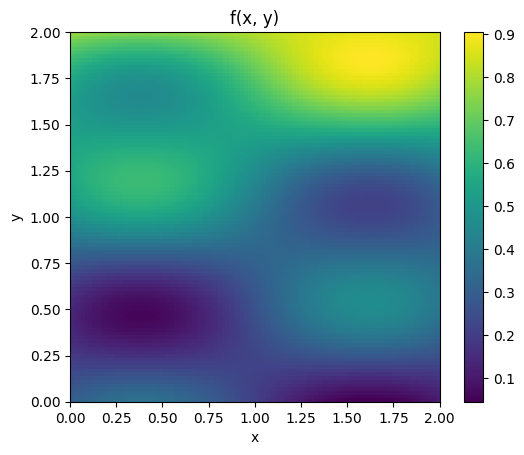

In [10]:
# Define the grid
x = np.linspace(0, 2, 100)
y = np.linspace(0, 2, 100)
X, Y = np.meshgrid(x, y)
grid = np.stack((X, Y), axis=-1)

# Evaluate the function on the grid
Z = f(torch.tensor(grid)).numpy()

# Plot the values using plt.imshow()
plt.imshow(Z, extent=[0, 2, 0, 2], origin='lower', cmap='viridis')
plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('f(x, y)')
plt.show()

## Sample data

In [12]:
# Randomly draw 100 points from [0,2]^2
x_train = torch.rand(100, 2) * 2

# Compute y_train = f(x_train)
y_train = f(x_train).detach()


## Train GP with matern kernel

### Define GP class

In [16]:
# Define the Gaussian process model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, likelihood_noise=1e-4, ard_num_dims=None):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        if ard_num_dims is not None:
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(nu=2.5, ard_num_dims=ard_num_dims)
                )
        else:
            self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.MaternKernel(nu=2.5)
                )
        self.likelihood_noise = likelihood_noise

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

### Train without ARD

In [30]:
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(x_train, y_train, likelihood)

# Set the model and likelihood to training mode
model.train()
likelihood.train()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Define the loss function as the negative marginal log-likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
num_epochs = 500
losses_list = []
for epoch in tqdm(range(num_epochs)):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(x_train)

    # Compute the loss
    loss = -mll(output, y_train)
    losses_list.append(loss.item())

    # Backward pass
    loss.backward()

    # Update the model parameters
    optimizer.step()


100%|██████████| 500/500 [00:01<00:00, 491.96it/s]


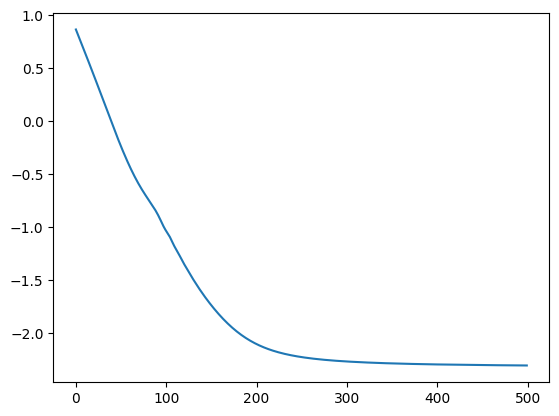

In [31]:
plt.plot(losses_list)
plt.show()

In [32]:
# check kernel lengthscale
model.covar_module.base_kernel.lengthscale

tensor([[1.0529]], grad_fn=<SoftplusBackward0>)

### Matern kernel with ARD

In [27]:
# Initialize the likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(x_train, y_train, likelihood, ard_num_dims=2)

# Set the model and likelihood to training mode
model.train()
likelihood.train()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

# Define the loss function as the negative marginal log-likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
num_epochs = 500
losses_list = []
for epoch in tqdm(range(num_epochs)):
    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    output = model(x_train)

    # Compute the loss
    loss = -mll(output, y_train)
    losses_list.append(loss.item())

    # Backward pass
    loss.backward()

    # Update the model parameters
    optimizer.step()

100%|██████████| 500/500 [00:01<00:00, 437.14it/s]


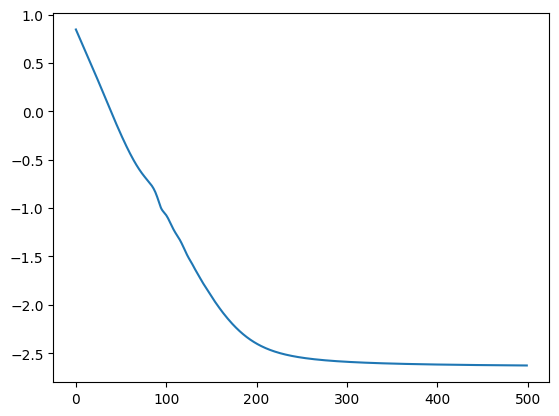

In [28]:
plt.plot(losses_list)
plt.show()

In [29]:
model.covar_module.base_kernel.lengthscale

tensor([[0.7348, 0.4191]], grad_fn=<SoftplusBackward0>)